# Sparse Collab AE


## Intro
* **Date**: 12/11/2020
* **What**: Remember [this guy](../../Reductionist%20Quasi-Isomorphisms/11_20_2020_experiment_collaborative_ae)?  The collaborative auto-encoder?  That horribly linear atrocity?  Well so do I!  Basically, I'm rebuilding that bad boi, but this time, I'm going to add a sparsity factor to really spice things up.  
* **Why**: Because my first attempt at sparse coding was an absolute dumpster fire (refer to last experiment if you want to view the dumpster fire).  More specifically, the collaborative ae was basically the only boi I've built that actually learned diverse features naturally, even though all of the neurons were being treated the same.  This is actually going to be fairly similar to DreamFlow as well, except there's no notion of winner-takes all. <br/><br/>  But yeah.  If there's one thing I've learned, it's that if you want to cultivate diversity, you really need to train the network based on its reconstruction abilities.  That's what worked for the Collab AE, and that's what worked for DreamFlow.
* **Hopes**: I really, *really* would like this network to learn some good ol' fashioned sparse features.  That would really just be the absolute sauce.  
* **Limitations**: Good heavens, the limitations section has really started to cultivate my cynicism.  I'll try not to be sarcastic.  Basically, there are a couple things that could happen here.  On the one hand, the network might basically just do pure population-coding, which is the collaborative auto-encoder's behavior.  On the other hand, the absolute worse-case scenario would be if the network converged to a bunch of fuzzy threes. I'm less concerned about that, but that has been the fate of most of my networks.  On the third hand growing directly out of my chest, the network might just straight-up learn a bunch of digit-prototypes.  I don't really see that happening, and I honestly wouldn't be super opposed to it, but it is a possibility, I suppose.

## Code

In [43]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from time import sleep, time
from scipy.special import expit as sig

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x / 255.0, test_x / 255.0

L = 28 * 28

flat_x = train_x.reshape(-1, L)
flat_test = test_x.reshape(-1, L)

S = flat_x.shape[0]

In [27]:
def draw_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((28 * Kx, 28 * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * 28: (y + 1) * 28, x * 28: (x + 1) * 28] = w[w_i].reshape(28, 28)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Reds", vmax=max_val, vmin=0)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

## Analysis Dialog

Ok fam.  So I'm going to start off with just the bare-bones collaborative ae.  I'm mostly doing this as a control for future trials, but also because I've been conditioned to believe that feature diversity is about as rare as unicorns, so I'd like to see some hard evidence that the collab-ae actually learns diverse features.  It's hard to even call them features because if memory serves, they're basically pixels, but whatever.  

<IPython.core.display.Javascript object>


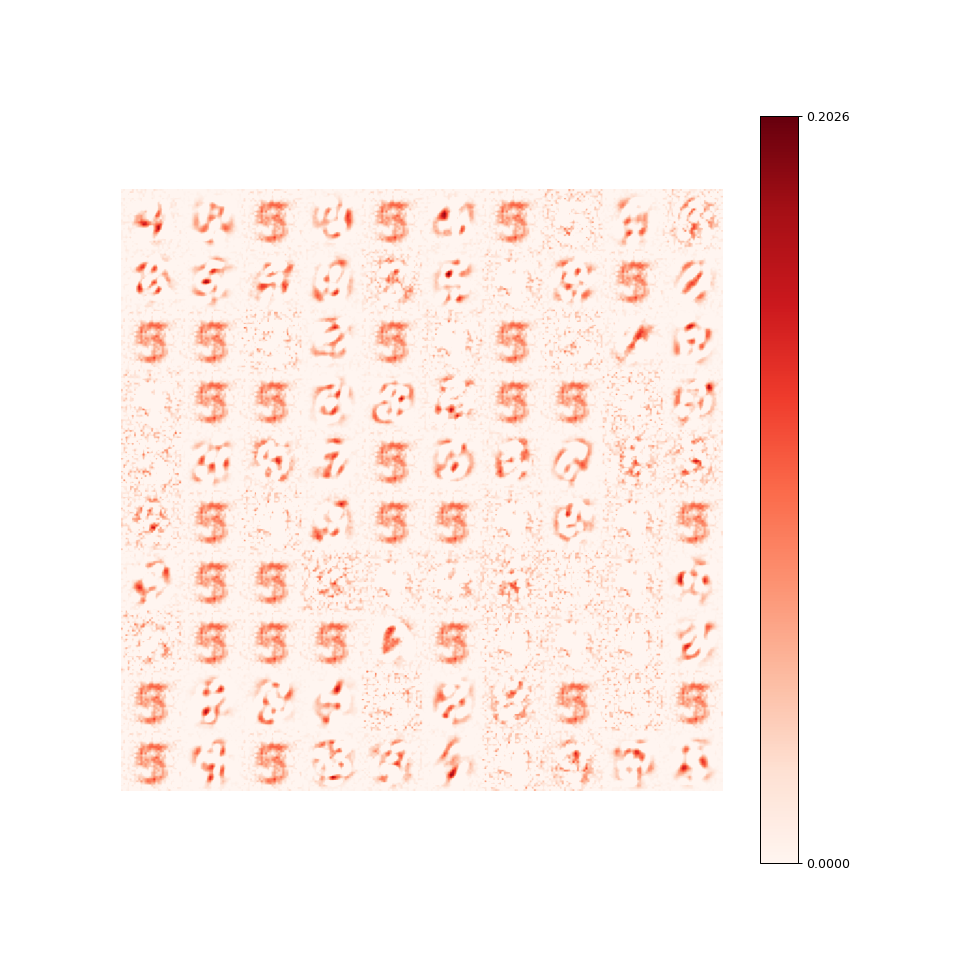

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1307.49it/s]


In [36]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 2
T_s = 10000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.001

w = np.random.uniform(0, 1, (N, L))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = (w @ v) / np.sum(w, axis=1).reshape(-1, 1)
        r = w.T @ o
        e = v - r
            
        w += xi * o * e.T
        w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

    draw_weights(w, Kx, Ky, fig)
        

Well, that makes me want to snap my own shin.  Why the literal fuck is that happening.  I'm going to dip into my rust code and see what the literal fuck is different about the above.  Suffice it so say that I am very displeased with this network's behavior.

<IPython.core.display.Javascript object>


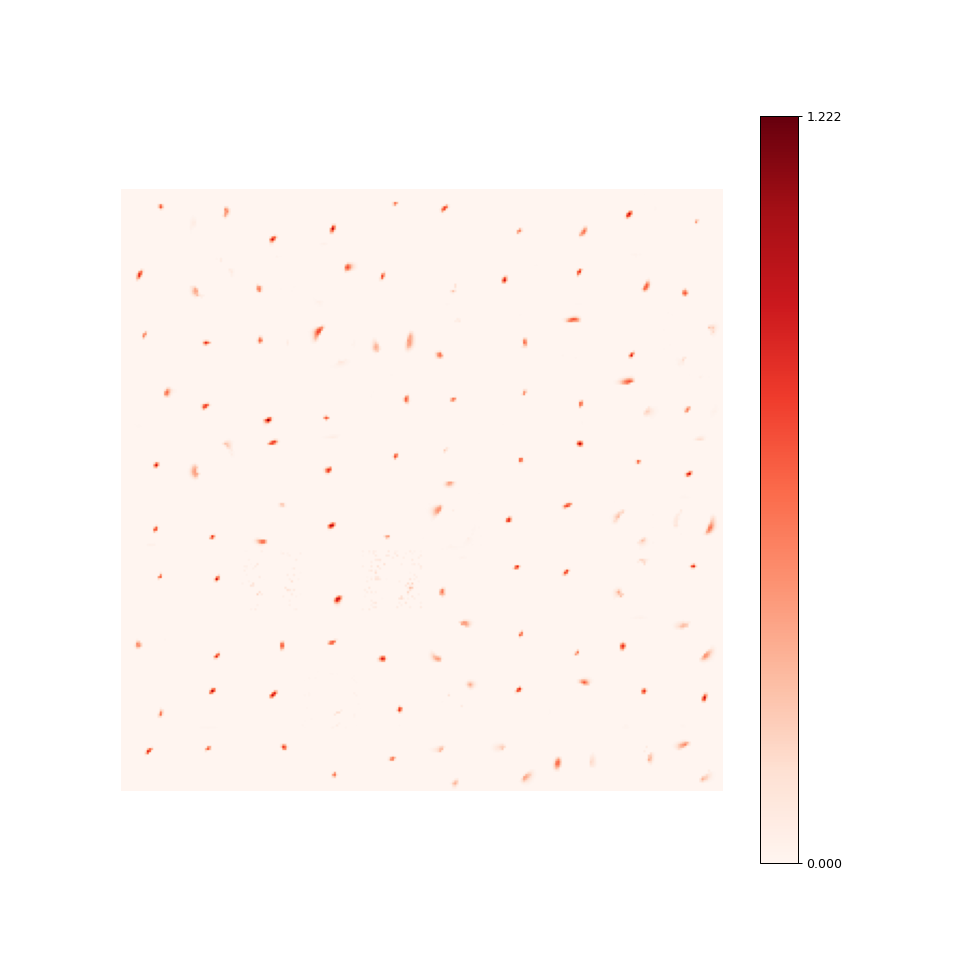

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [01:03<00:00, 951.38it/s]


In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 5
T_s = 60000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.0002

w = np.random.uniform(0, 1, (N, L))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = (w @ v) / np.sum(w, axis=1).reshape(-1, 1)
        r = w.T @ o
        e = v - r
            
        w += xi * o * e.T
        w = np.maximum(w, 0)

    draw_weights(w, Kx, Ky, fig)
    

Ok, so everything works just fine if I use a super, super small learning constant.  I'll tell you what I'm not happy about tho. Why the fuck is it taking a full minute to cycle through 100 samples???



In [38]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

Returns: (synapse_weights, neuron specialization values)
"""
def run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B, :]

            w_mul_v = w @ v.T 
            o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

            c = ((1 - s) ** 2) / (1 - o)

            wins = np.argmax(c, axis=0)     

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            del_syn = (v_update - (win_avg * w)) * (((1 - s) ** 2) + 0.1) * xi

            w += del_syn

            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

#         draw_weights(w, Kx, Ky)

    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 613.28it/s]


Max val:  0.9370395414566883 Min value:  0.6284796477988268 Mean val:  0.8566345978060623 Std:  0.04076548532990188
Elapsed time:  1.1848337650299072  seconds





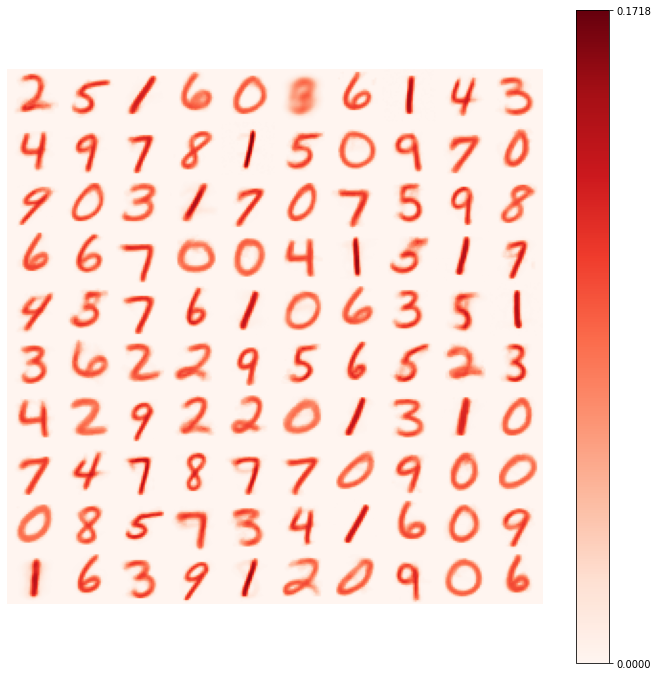

In [40]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 100 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
draw_weights(w, Kx, Ky, fig)

Huh.  I just brought that in to see if the computer's running slower than normal.  Spoiler alert, it isn't.  So I guess I'm just going to have to deal with those incredibly slow speeds.

Strangely enough, the OG non-batched CompSpec network took about 10 seconds to run 60,000 images.  I have no idea why this one would be so much slower.  Maybe because I'm allocating memory during the loop?  I don't know.

Ok, so I'm going to work out and eat lunch, but when I come back, I'm going to do some stuff to make the "control" hopefully way faster.  Peace.

Ok, we back baby.  Time to do non-competitive DreamFlow.  That's what it's come to.  I mean, it's essentially doing the same thing as the above code, but this time it isn't horse shit.  Aight let's do this.

<IPython.core.display.Javascript object>


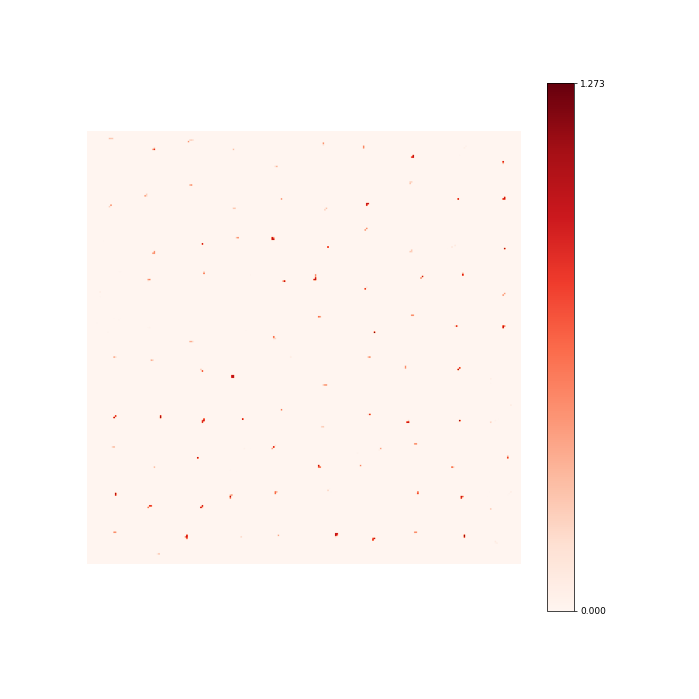

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2253.19it/s]


In [54]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 1
T_s = 1000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.001
prec = 1e-10

w = np.random.uniform(0, 1, (N, L))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig(w @ v)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T

    draw_weights(w, Kx, Ky, fig)

Now, that's what I'm talking about.  That's the juice.  Wow I'm doing 20 lines of code in python what I used to do with like 250 in Rust.  Gotta love public libraries.  Gotta love numpy.  You'll notice that it "converges" to the population coding after only like 1000 images.  I'm going to play with this a bit, see what I can get.

<IPython.core.display.Javascript object>


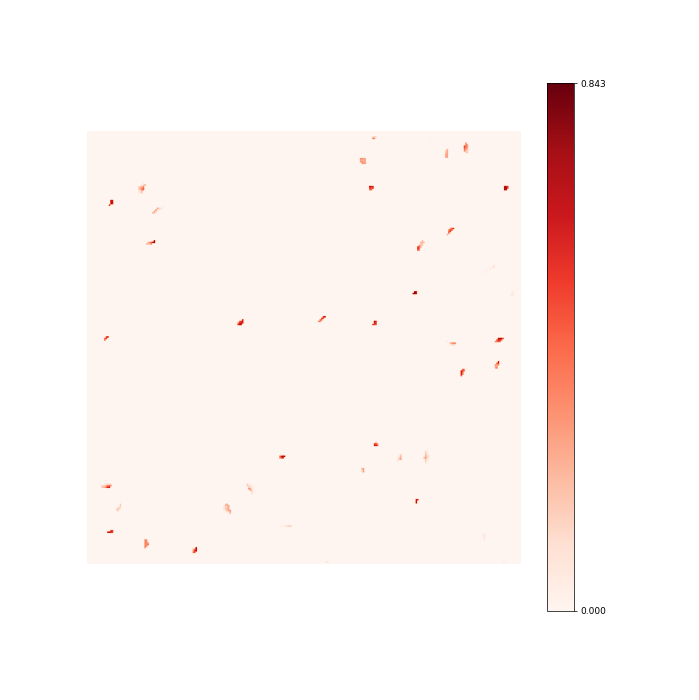

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.25it/s]


In [64]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.1
prec = 1e-10

w = np.random.uniform(0, 1, (N, L))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig(w @ v)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi

    draw_weights(w, Kx, Ky, fig)

I forgot to include xi!  Silly goose.  I was wondering why the weights were moving around so much.  Ok, now that I got the learning constant down a bit, everything is much more stable.  That being said, the weights this bad boi is learning don't look particularly compelling.  I'm going to draw the weights with the max weight cut down lower to see what the other features are being learned.

<IPython.core.display.Javascript object>


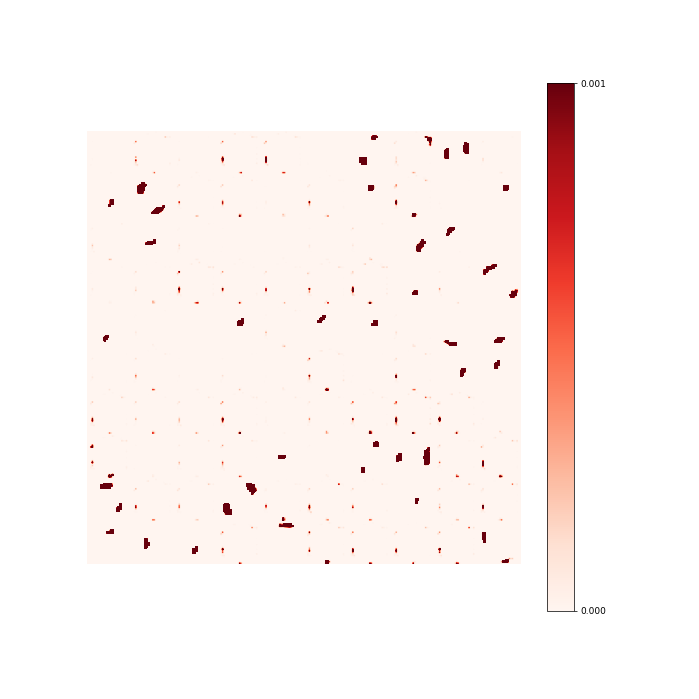

In [68]:
fig = plt.figure(figsize=(12, 12))

tapestry = np.zeros((28 * Kx, 28 * Ky))

w_i = 0
for y in range(Ky):
    for x in range(Kx):
        tapestry[y * 28: (y + 1) * 28, x * 28: (x + 1) * 28] = w[w_i].reshape(28, 28)
        w_i += 1

plt.clf()        
max_val = 0.001
im = plt.imshow(tapestry, cmap="Reds", vmax=max_val, vmin=0)
fig.colorbar(im, ticks=[0, max_val])
plt.axis("off")
fig.canvas.draw()

Wow, so it looks like a couple prototypes are dominating the scene.  You'll notice how aggressively I had to cut that off as well.  Also, why the snarfalofogous did the loops get so much slower?  I think it may be because it has to deal with the extremely small numbers.  Hmm.  I'll cut off the weights if the pass `prec`.  That'll probably do it.

<IPython.core.display.Javascript object>


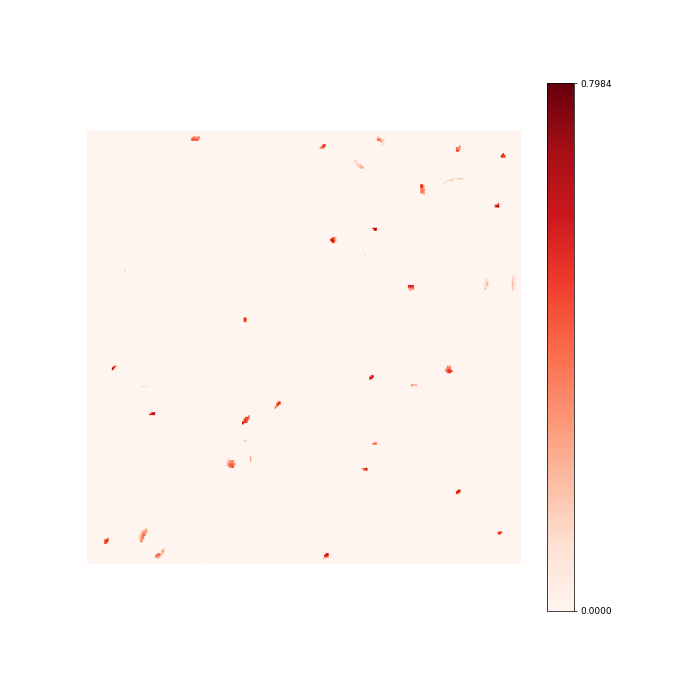

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:26<00:00, 2281.33it/s]


In [71]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 1
T_s = 60000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.1
prec = 1e-10

w = np.random.uniform(0, 1, (N, L))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig(w @ v)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, fig)

Yeah that did the trick.  Wow it seems like the network isn't learning super good features.  Before we sparsify, I'm going to see what happens if I boost xi.

<IPython.core.display.Javascript object>


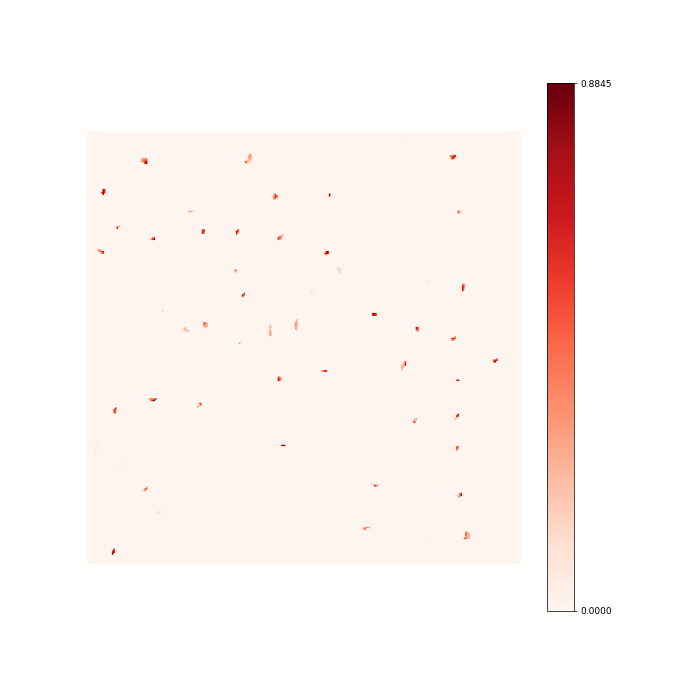

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2097.85it/s]


In [73]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 1000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.3
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, L))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig(w @ v)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, fig)

Hmm, so if I boost $\xi$, then the network learns more dots.  Hmm cool.  I think it's high time we added some sparsity don't you?  

I'm just going to modify the threshold, as in the Foldiak network.

<IPython.core.display.Javascript object>


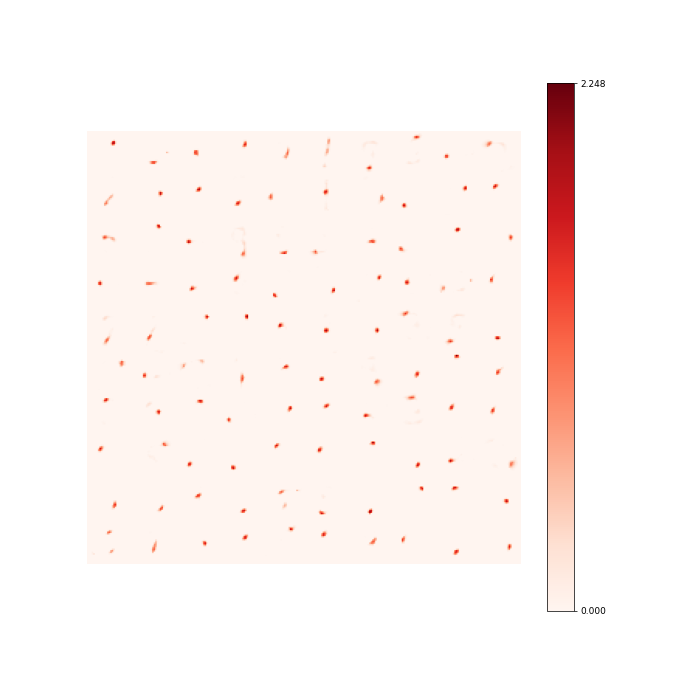

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2230.14it/s]


In [77]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.01
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, L))
t = np.zeros((N, 1))
sp = 0.1
gamma = 0.01


for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, fig)

Well, this is simply fantastic.  By adding the sparsity term, we've basically recruited all the neurons.  The neurons are still quite basic in formation.  But you know what?  I think we can change that!  If I push the sparsity activation down to 0.01, it should hopefully be winner takes all... Let's see!

<IPython.core.display.Javascript object>


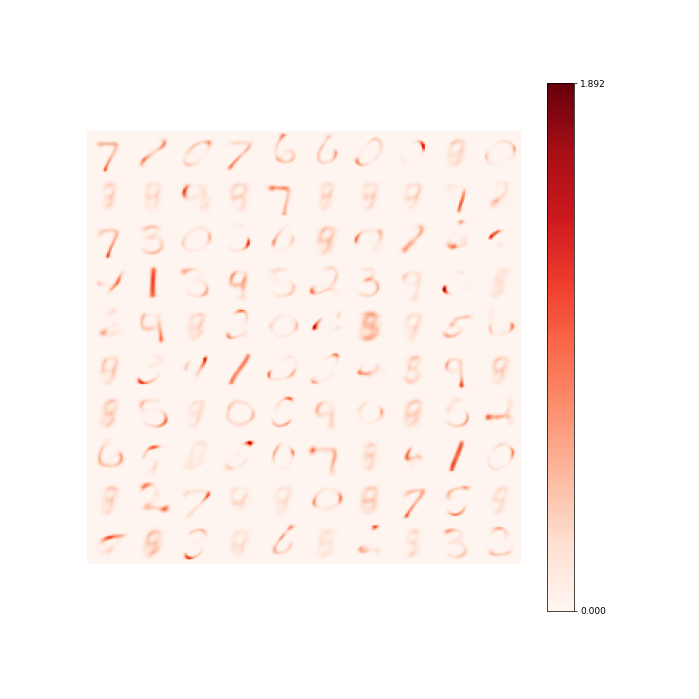

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2201.26it/s]


In [79]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.01
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, L))
t = np.zeros((N, 1))
sp = 0.01
gamma = 0.01


for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, fig)

In [81]:
t.reshape(-1)

array([29.87047426, 26.12257657, 24.52261659, 27.21904892, 27.84956251,
       24.81474331, 16.59726585, 18.91933526, 30.87907326, 17.87435162,
       27.50255781, 25.55032742, 22.11685341, 30.99727505, 30.4888646 ,
       26.75014718, 27.52450427, 24.99088107, 26.53585433, 19.47971528,
       29.61420913, 30.54410979, 23.27957394, 20.21619827, 20.77055915,
       39.52758981, 22.00948253, 22.41024072, 20.74938267, 22.10888357,
       23.57363523, 43.87400453, 24.70133607, 25.69273372, 19.32411461,
       23.08969209, 28.29490406, 19.53797869, 20.4395577 , 21.44873889,
       19.23422805, 31.1894291 , 31.6143535 , 24.78062508, 18.40042775,
       22.37176361, 30.44125825, 24.30362511, 26.85660783, 20.52990582,
       32.57002597, 21.95493663, 24.43100033, 39.61760739, 20.21388552,
       16.67183896, 21.74718743, 32.07048924, 29.57398546, 33.79483587,
       37.37221405, 24.17594314, 21.23927163, 30.65950709, 23.5819071 ,
       27.44652337, 17.48504085, 37.68615263, 24.26203098, 26.72

That's not too bad!  You can definitely see the shapes of the prototypes.  I wonder what happens if I push the sparsity down even further.  Imma mess around with this for a little.

<IPython.core.display.Javascript object>


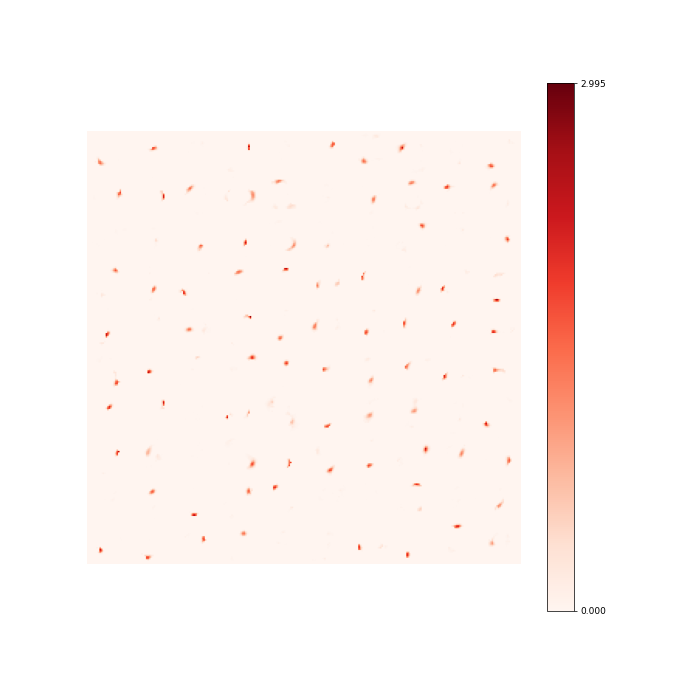

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2139.27it/s]


In [91]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, L))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.001


for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, fig)

Ok, after messing with sp < 0.001, nothing much happened.  The network really just wants to learn a bunch of dots.  Ok network.  You can do that.  I'm not going to fight you.  I kinda want to see how this does on cifar10.  It's probably going to learn a bunch of weird shit.  That's ok.  I can't imagine it'll be worse than the Foldiak network.  I'm still not 100% convinced I didn't mess that up.  But I'll still bash him.  Whatever.

In [102]:
from tensorflow.keras.datasets import cifar10

(tr_x, _), _ = cifar10.load_data()

l = 32 * 32

gray_x = np.linalg.norm(tr_x, axis=3).reshape(-1, l)
gray_x /= np.max(gray_x)

In [105]:
def draw_cifar_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((32 * Kx, 32 * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * 32: (y + 1) * 32, x * 32: (x + 1) * 32] = w[w_i].reshape(32, 32)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys_r", vmax=max_val, vmin=0)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


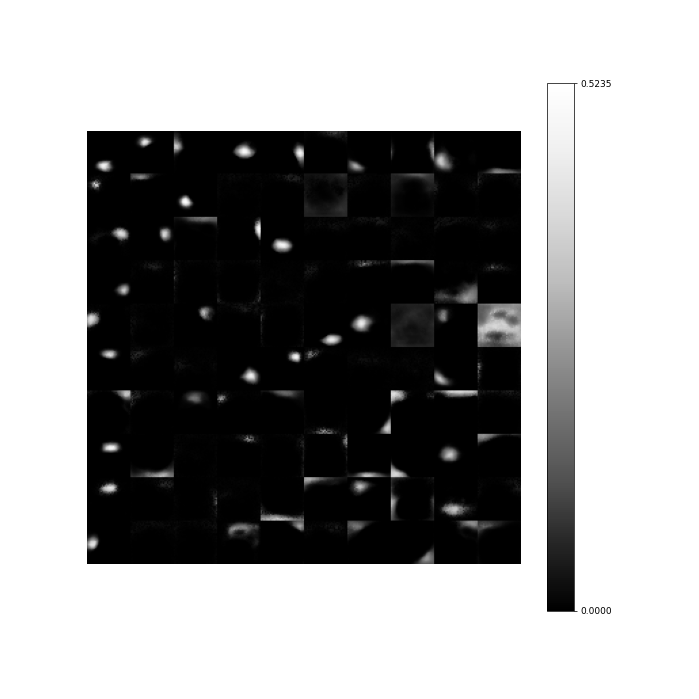

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1955.92it/s]


In [108]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, l))
t = np.zeros((N, 1))
sp = 0.1
gamma = 0.001


for ep in range(Nep):
    inputs = gray_x[np.random.permutation(T_s)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_cifar_weights(w, Kx, Ky, fig)

Wow.  That's actually kinda wild.  And, I mean, this bad boi is crazy undercomplete.  Just for funzies, I'm going to train this with 400 neurons and see what happens.

<IPython.core.display.Javascript object>


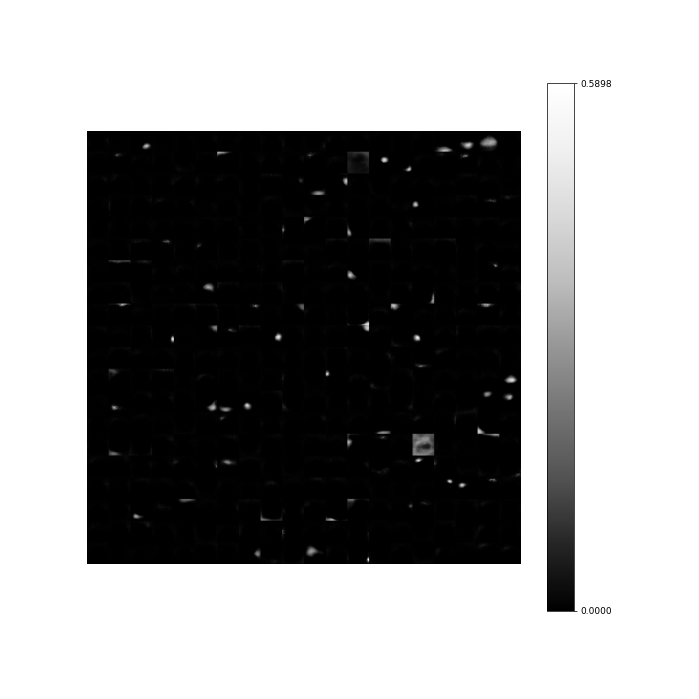

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:00<00:00, 167.17it/s]


In [110]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, l))
t = np.zeros((N, 1))
sp = 0.1
gamma = 0.001


for ep in range(Nep):
    inputs = gray_x[np.random.permutation(T_s)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_cifar_weights(w, Kx, Ky, fig)

Well, I'm not sure what more I could want from that.  Here's something tho.  How about I cut out a 10x10 image, and we train on that?  Then it would be overcomplete.  Juice.

In [113]:
g = 10
g2 = g // 2

sm_flat_x = np.linalg.norm(tr_x, axis=3)[:, 16-g2:16+g2, 16-g2:16+g2].reshape(-1, g * g)

sm_flat_x /= np.max(sm_flat_x)

In [120]:
def draw_cifar_mini_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((10 * Kx, 10 * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * 10: (y + 1) * 10, x * 10: (x + 1) * 10] = w[w_i].reshape(10, 10)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys_r", vmax=max_val, vmin=0)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


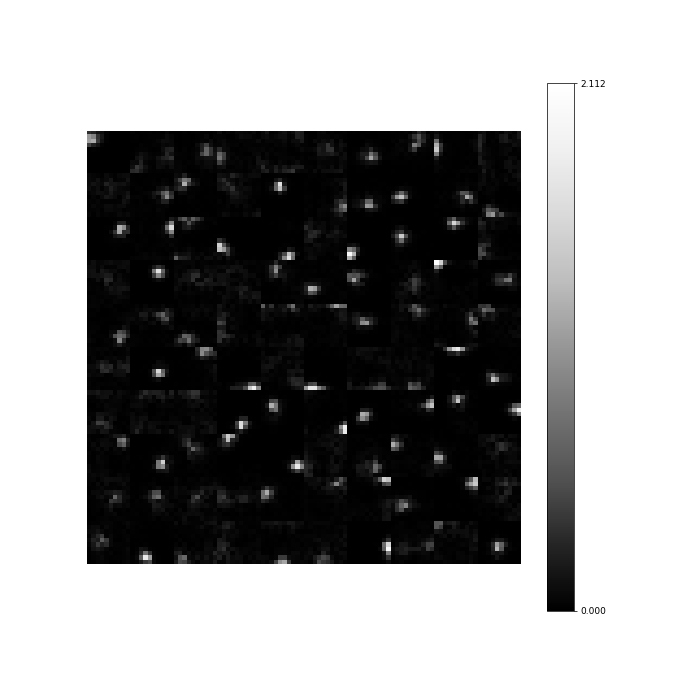

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4017.17it/s]


In [127]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, g ** 2))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.001


for ep in range(Nep):
    inputs = sm_flat_x[np.random.permutation(T_s)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_cifar_mini_weights(w, Kx, Ky, fig)

Hmm... Let's see what happens when we train 400 neurons?

<IPython.core.display.Javascript object>


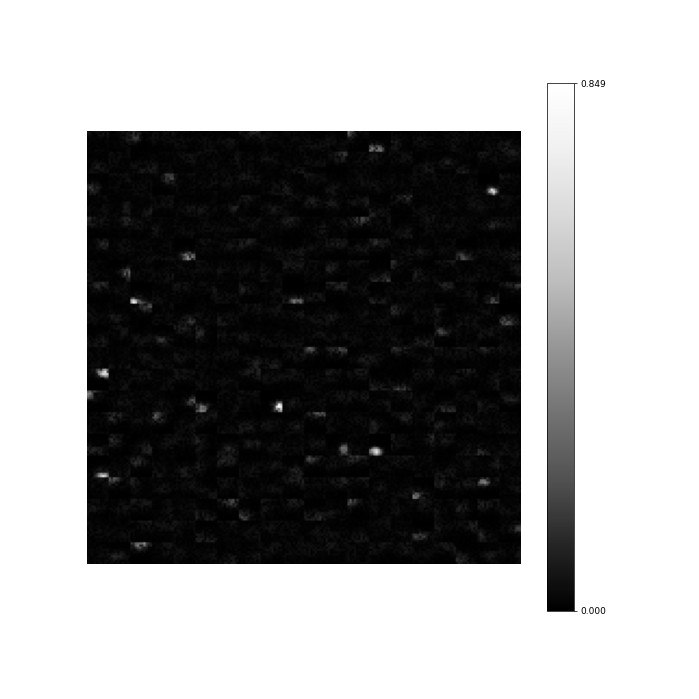

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3060.66it/s]


In [129]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 10000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, g ** 2))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01


for ep in range(Nep):
    inputs = sm_flat_x[np.random.permutation(T_s)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_cifar_mini_weights(w, Kx, Ky, fig)

Hmm.  I straight up don't know what to think.  I'm going to train it on 10 epochs of 60,000, and then I'm going to do some reconstructions, see how we juicin.

<IPython.core.display.Javascript object>


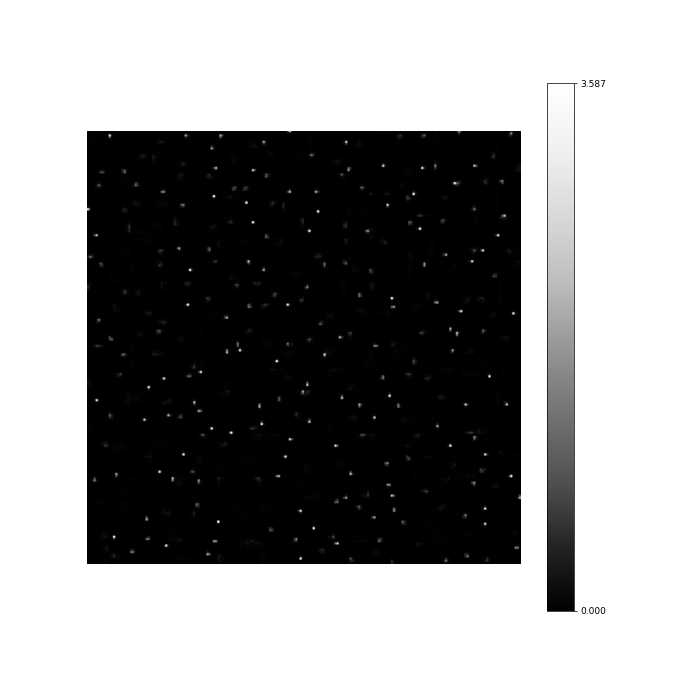

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:16<00:00, 3069.66it/s]


In [131]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 50000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, g ** 2))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01


for ep in range(Nep):
    inputs = sm_flat_x[np.random.permutation(T_s)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_cifar_mini_weights(w, Kx, Ky, fig)

Hmm.  Ok, I suppose that's pretty compelling.  I don't know if we're getting Gabor functions though.  I'll plot a couple of the weights a bit bigger.

<IPython.core.display.Javascript object>


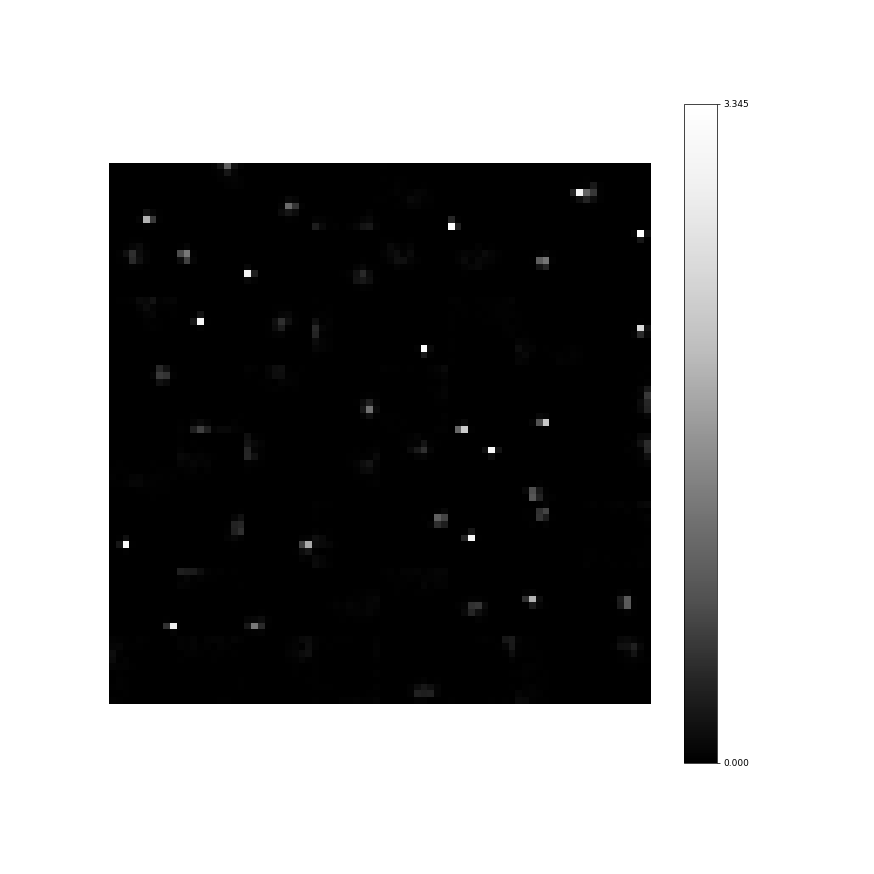

In [135]:
fig = plt.figure(figsize=(15, 15))

draw_cifar_mini_weights(w[50:114], 8, 8, fig)

Yeah, it doesn't really look like Gabor functions. I'm going to plot them individually, see how that goes.

<IPython.core.display.Javascript object>


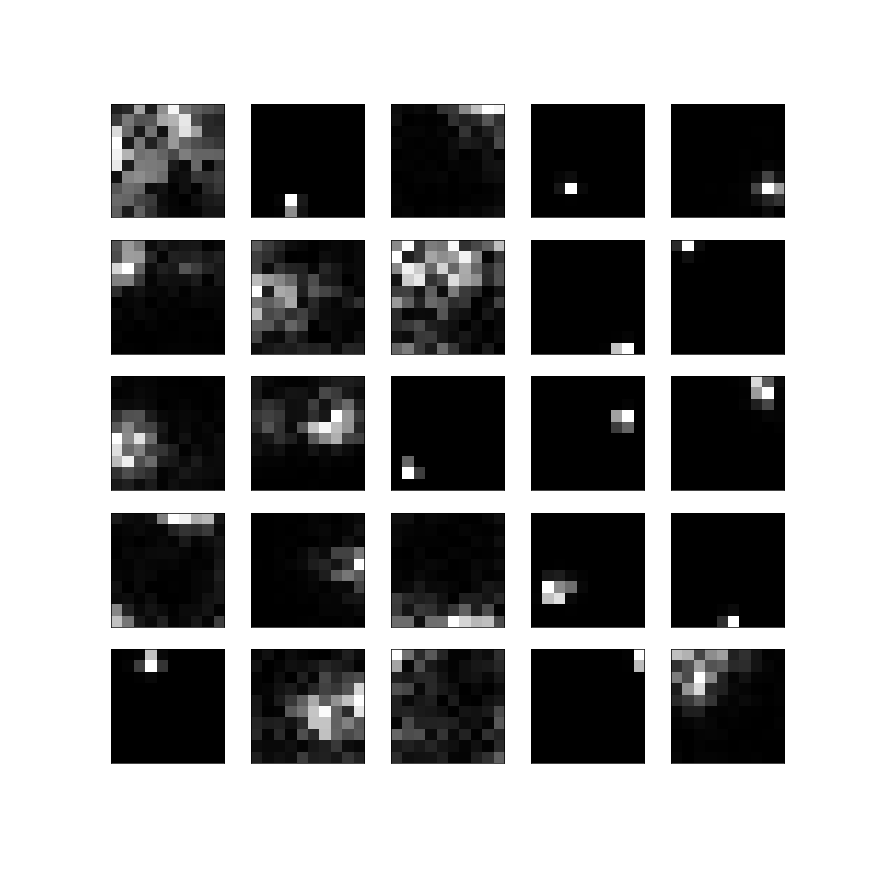

In [145]:
fig = plt.figure(figsize=(15, 15))

offset = 300
Kx = 5
Ky = 5

for i in range(Kx * Ky):
    plt.subplot(Kx, Ky, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(w[offset + i].reshape(10, 10), cmap='Greys_r')
plt.show()

You know what?  Some of those kinda do look like Gabor functions.  But like, barely.

I think it's time to do some reconstructions.

<IPython.core.display.Javascript object>


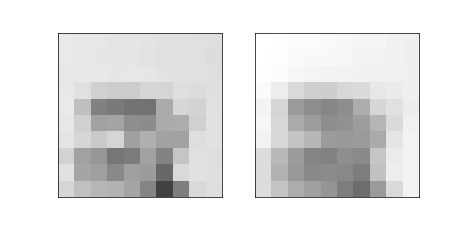

In [147]:
img_i = 100

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


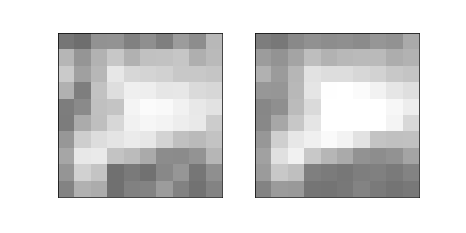

In [148]:
img_i = 0

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


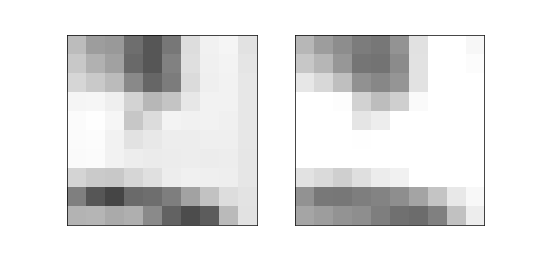

In [149]:
img_i = 1

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


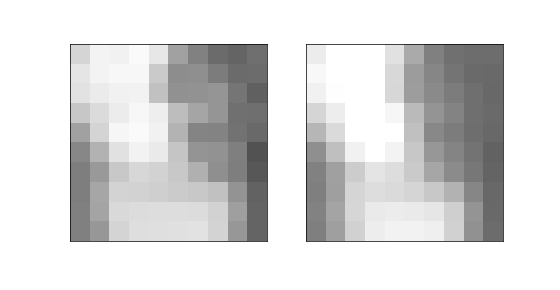

In [150]:
img_i = 101

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

Wow.  All things considered, it isn't doing horribly.  It's getting most of the structure.  

Ok, there are two more things I want to do.  Well, there's actually a ton more I want to do.  But first things first, I want to train this bad boi with like 900 neurons.  Then, I want color baby.

<IPython.core.display.Javascript object>


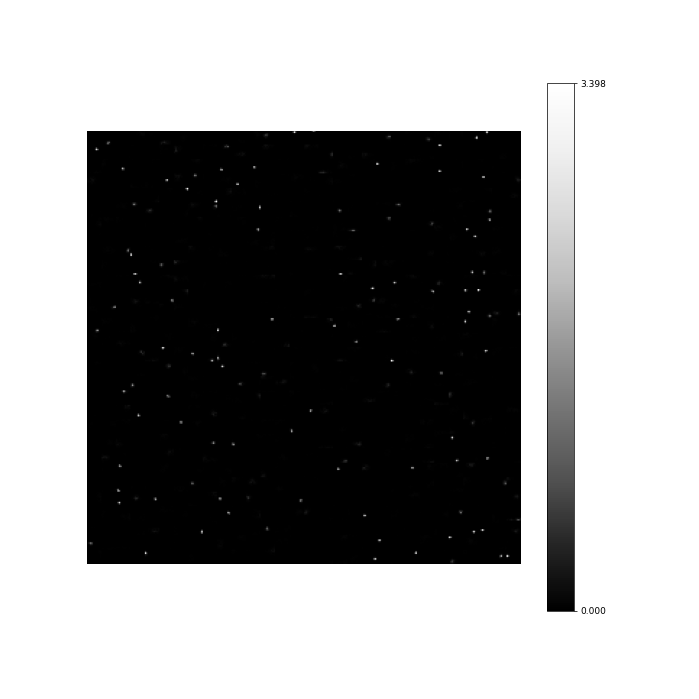

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:23<00:00, 2085.25it/s]


In [151]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 50000
Kx = 30
Ky = 30
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, g ** 2))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01


for ep in range(Nep):
    inputs = sm_flat_x[np.random.permutation(T_s)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_cifar_mini_weights(w, Kx, Ky, fig)

<IPython.core.display.Javascript object>


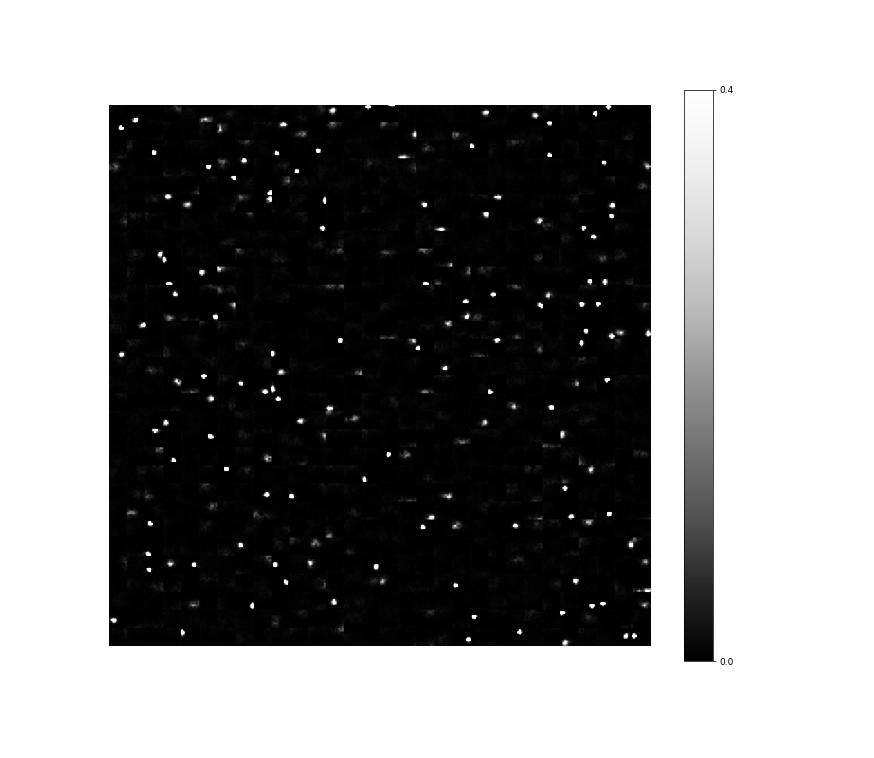

In [160]:
fig = plt.figure(figsize=(15, 13))

tapestry = np.zeros((10 * Kx, 10 * Ky))

w_i = 0
for y in range(Ky):
    for x in range(Kx):
        tapestry[y * 10: (y + 1) * 10, x * 10: (x + 1) * 10] = w[w_i].reshape(10, 10)
        w_i += 1

plt.clf()        
max_val = 0.4
im = plt.imshow(tapestry, cmap="Greys_r", vmax=max_val, vmin=0)
fig.colorbar(im, ticks=[0, max_val])
plt.axis("off")
fig.canvas.draw()

Interesting.  I'm going to do the same stuff as last time.

<IPython.core.display.Javascript object>


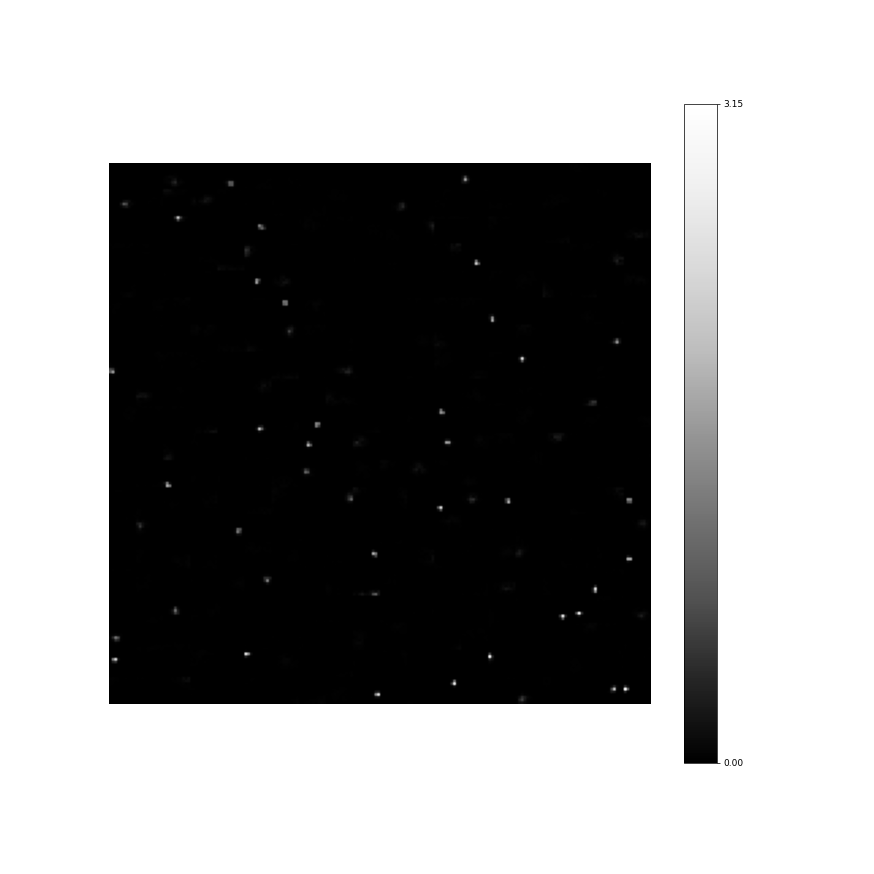

In [165]:
fig = plt.figure(figsize=(15, 15))
offset = 500
rg = 20
draw_cifar_mini_weights(w[offset:offset + rg ** 2], rg, rg, fig)

<IPython.core.display.Javascript object>


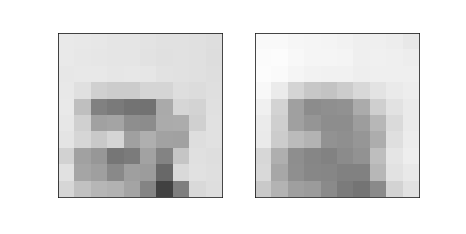

In [166]:
img_i = 100

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


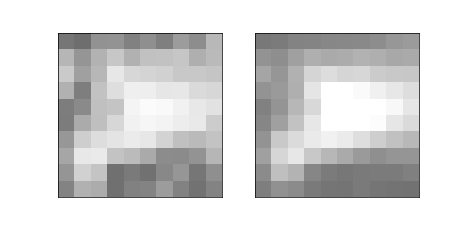

In [167]:
img_i = 0

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


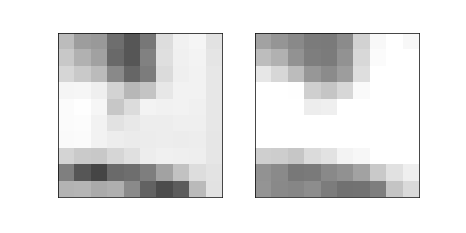

In [168]:
img_i = 1

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


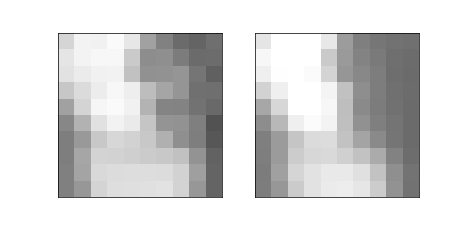

In [169]:
img_i = 101

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

Well fam, I can't really tell if this is much better than the 400 boi.  You know what?  Imma do 900 again, but I'm going to bump the sparsity.

<IPython.core.display.Javascript object>


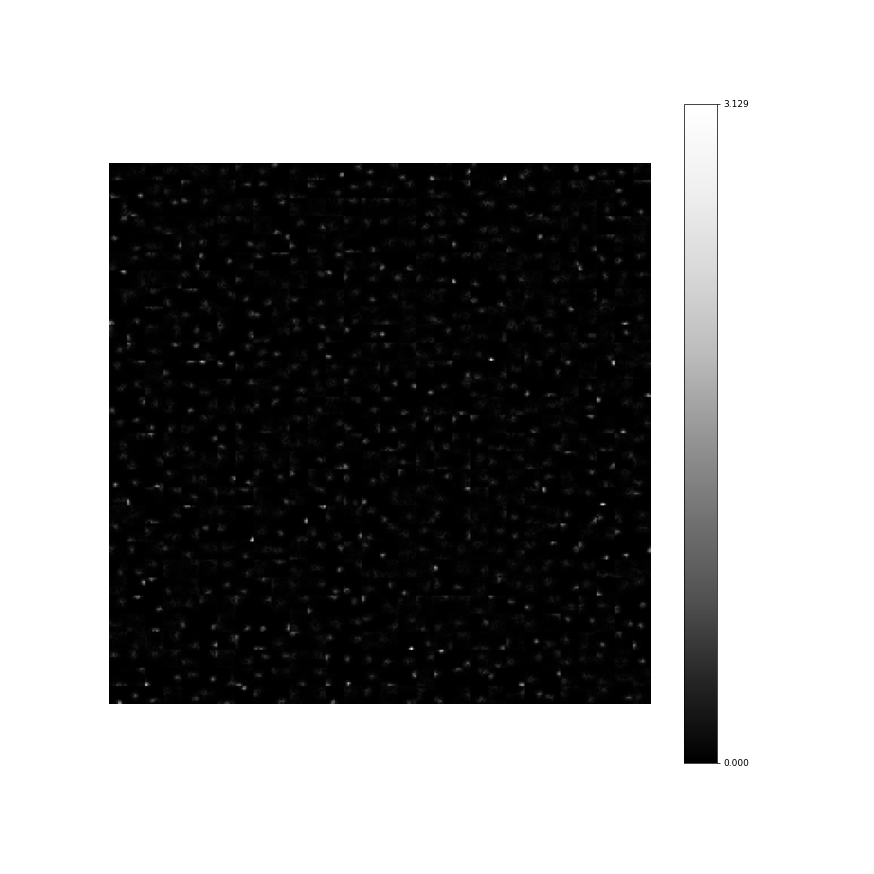

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:23<00:00, 2148.62it/s]


In [171]:
%matplotlib notebook
fig = plt.figure(figsize=(15, 15))

Nep = 10
T_s = 50000
Kx = 30
Ky = 30
N = Kx * Ky
xi = 0.02
prec = 1e-10

w = np.random.uniform(0.1, 1, (N, g ** 2))
t = np.zeros((N, 1))
sp = 0.01
gamma = 0.01


for ep in range(Nep):
    inputs = sm_flat_x[np.random.permutation(T_s)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        o = sig((w @ v) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_cifar_mini_weights(w, Kx, Ky, fig)

Ok, here's the same stuff as last time.

<IPython.core.display.Javascript object>


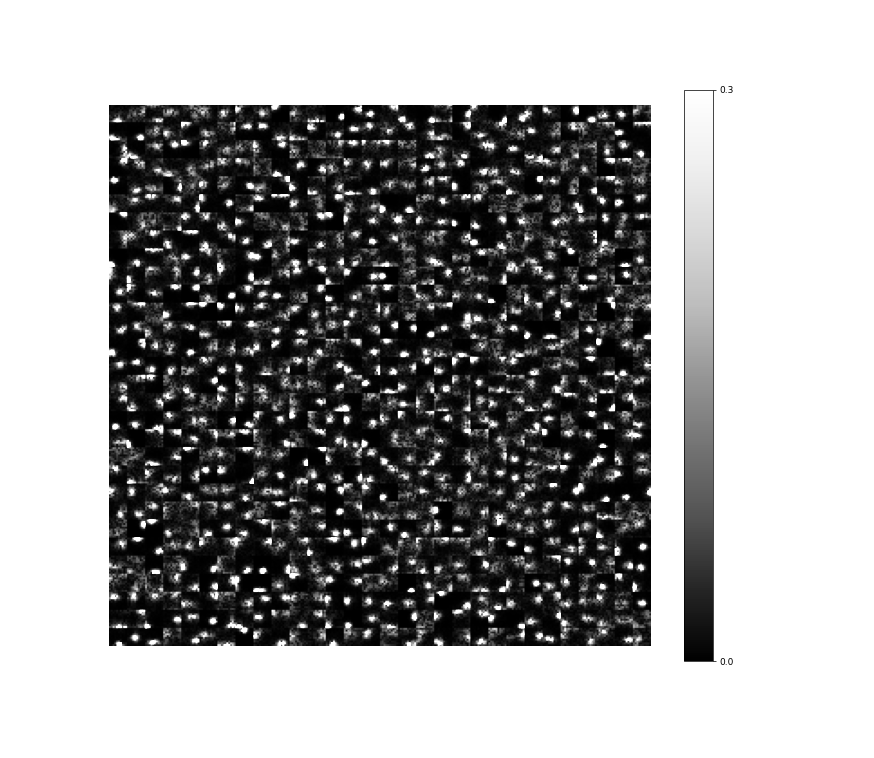

In [173]:
fig = plt.figure(figsize=(15, 13))

tapestry = np.zeros((10 * Kx, 10 * Ky))

w_i = 0
for y in range(Ky):
    for x in range(Kx):
        tapestry[y * 10: (y + 1) * 10, x * 10: (x + 1) * 10] = w[w_i].reshape(10, 10)
        w_i += 1

plt.clf()        
max_val = 0.3
im = plt.imshow(tapestry, cmap="Greys_r", vmax=max_val, vmin=0)
fig.colorbar(im, ticks=[0, max_val])
plt.axis("off")
fig.canvas.draw()

<IPython.core.display.Javascript object>


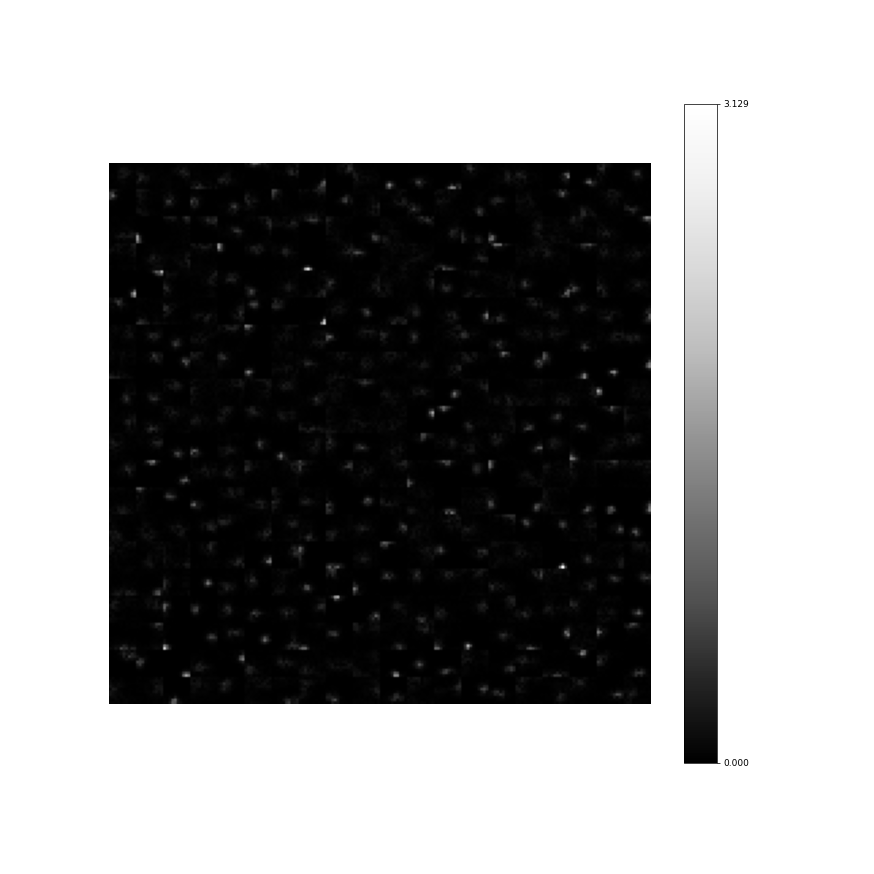

In [174]:
fig = plt.figure(figsize=(15, 15))
offset = 500
rg = 20
draw_cifar_mini_weights(w[offset:offset + rg ** 2], rg, rg, fig)

<IPython.core.display.Javascript object>


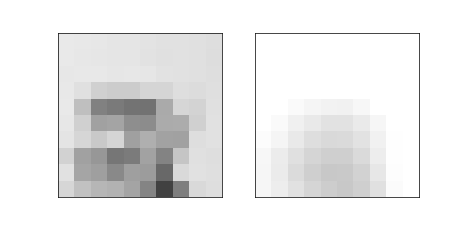

In [175]:
img_i = 100

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


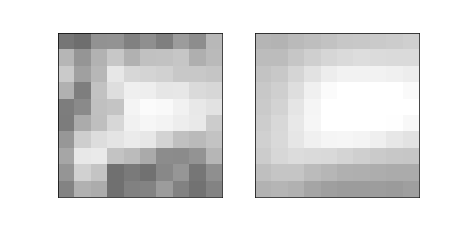

In [176]:
img_i = 0

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


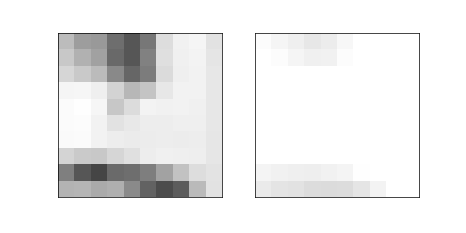

In [177]:
img_i = 1

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

<IPython.core.display.Javascript object>


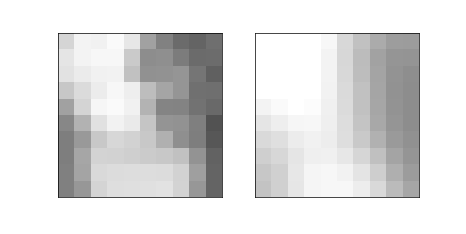

In [178]:
img_i = 101

img = sm_flat_x[img_i]

v = img.reshape(-1, 1)
o = sig((w @ v) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(10, 10), cmap='Greys_r', vmin=0, vmax=1)

plt.show()

Interesting!  It looks like the effect of this network is to significantly smooth out the image.  Why does the 900 neuron network simply the image more than the 400 network?  Well, blessed reader (probably me), I set the sparsity of the 900 neuron network so only about 9 neurons are firing at a time.  The 400 neuron network's sparsity is such that about 20 neurons fire at once.  So, we should expect the 400 neuron network to have better resolution than the 900 neuron network.  

Man, I'd love to see how this does reconstructing bigger images, where I can actually make out the structure of everything with my good good neural network.

I think this is a good enough start.  This experiment has become pretty long, so I think I'm going to finish it out.  

## Conclusions

Well, after a rocky start, we straight boolin' bois!  The collaborative ae is basically a heap of garbage, and as much as I love Rust, it was kinda a massive failure in the beginning of this adventure.

Anyway, the DreamFlow-like synthesis works like a charm.  Not only does it work, but the sparsity factor plays super nice with it.  

I don't really have a lot to report besides that.  Actually I should say that I'm quite happy that I'm super happy this network actually works pretty well with cifar10.  I'm getting a little tired of mnist, not gonna lie, and I want to see colors.  The grayscale cifar10 is a step in the right direction, however.  

Actually, I should also mention that when I trained this on gray cifar10, the network super did not learn the nice looking gabor filters like the topographic ICA paper.  That would've been cool, I guess.  However, it looks qualitatively like my network is doing a pretty good job at reconstruction, so I'm not super concerned.

That being said Hyvarinen apparently used a bunch of image preprocessing before he trained the network, so that's kinda cheating IMO.  He also was training on 16x16 images.  Maybe if I did that, I'd be able to see Gabor filters clearer.  Who knows.  Also, Hyvarinen only used nature scenes.  I, however, am using a bunch of dirty man-made objects in my images (cifar10, bitches), so maybe I would've gotten more distinctive images had I only used nature images.  I kinda doubt it, tho.

## Next steps

Fam, I really, really want to train this topographically.  So local lateral connections, and non-local lateral inhibition in the hidden layer.  I think that might be super dope.  While I don't really expect to see the incredibly beautiful topography of features like in Hyvarinen's paper (topo ICA, 2001), but hopefully there will be a topographical structure to the hidden features.

I also really want to train this on color images, because then I can see the extent to which it's properly recreating real-life imagery.  Heck, I might send it and train it on the full cifar10 images.  Actually, no.  That would literally take hours.  Still 10x10s will probably do just fine in the beginning.  Hopefully.  

I'm also excited to investigate the structure of Hopfield networks, and specifically, dynamic attractors.  I've had some idea about how I might model invariances in structure using hidden neurons in dynamic Hopfield networks.  We'll see how that works.  I imagine I probably have a battle in front of me trying to get the Hopfield networks to work the way I want them to work.  We'll see.  

It took a week, but we back baby!  Take that, crippling anxiety!!